In [1]:
# Cell 1: Import libraries and set up environment
# This cell imports all necessary libraries for data handling, image processing, and model building.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [2]:
# Cell 2: Load dataset metadata and prepare file paths
# This cell loads CSV annotation files from the RSNA dataset and creates a simplified DataFrame with patient IDs and labels.
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
train_labels_csv = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_csv = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

labels_df = pd.read_csv(train_labels_csv)
class_info_df = pd.read_csv(class_info_csv)

merged_df = pd.merge(labels_df, class_info_df, on="patientId")
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple['patientId'] = labels_simple['patientId'].astype(str) + ".dcm"

print("✅ Metadata loaded successfully!")
print("Total records:", len(labels_simple))


✅ Metadata loaded successfully!
Total records: 26684


In [3]:
# Cell 3: Define image loading and preprocessing function
# This cell defines a function to load a DICOM file, normalize pixel values, resize to 224x224, and keep the image as grayscale.
def load_preprocess_dicom(dicom_path, img_size=(224, 224)):
    # Read the DICOM file and extract the pixel array
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize pixel intensities to [0, 1]
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize image to target dimensions (224x224)
    img_resized = cv2.resize(img_norm, img_size)
    # Ensure the image remains grayscale (i.e., add channel dimension)
    img_resized = np.expand_dims(img_resized, axis=-1)
    return img_resized

# Test the function on a sample image
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", labels_simple.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image loaded and preprocessed. Shape:", sample_img.shape)


✅ Sample image loaded and preprocessed. Shape: (224, 224, 1)


In [19]:
# Cell 4: Prepare data generators for training and validation
# This cell splits the dataset into training and validation sets and creates custom data generators.
from sklearn.model_selection import train_test_split

# Split dataset with stratification on 'Target' to keep class distribution similar
train_df, val_df = train_test_split(labels_simple, test_size=0.2, random_state=42, stratify=labels_simple['Target'])
print("Train samples:", len(train_df), "Validation samples:", len(val_df))

def data_generator(df, batch_size=64, img_size=(224, 224), infinite=False):
    def gen():
        for _, row in df.iterrows():
            patient_id = row['patientId']
            # Convert label to binary: 1 for Pneumonia, 0 for Normal
            label = 1 if row['Target'] == 'Pneumonia' else 0
            dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
            img = load_preprocess_dicom(dicom_path, img_size)
            yield img, label
    # Create dataset from generator
    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((img_size[0], img_size[1], 1), ())
    )
    # If infinite is True, repeat indefinitely
    if infinite:
        ds = ds.repeat()
    # Apply shuffle, batch, and prefetch
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Create training dataset with infinite repeat, and validation without repeating
train_ds = data_generator(train_df, batch_size=64, infinite=True)
val_ds = data_generator(val_df, batch_size=64, infinite=False)


Train samples: 21347 Validation samples: 5337


In [20]:
# Cell 5: Build the basic CNN model for pneumonia classification
# This cell defines a simple CNN model with an explicit Input layer expecting grayscale images of shape (224, 224, 1).
model = Sequential([
    Input(shape=(224, 224, 1)),  # Updated to match our preprocessed images
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Use the initial learning rate defined in Cell 1 (0.001)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Cell 6: Set hyperparameters and define callbacks
# This cell uses hard-coded hyperparameters and defines callbacks to improve training.
# You can modify these values to experiment with different settings.
initial_learning_rate = 0.001  # Starting learning rate
epochs = 10                    # Increase epochs if necessary
batch_size = 64                # Already used in data generator; can be adjusted here too

# Callbacks:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping halts training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ReduceLROnPlateau reduces learning rate when a plateau is detected in validation loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("Hyperparameters set:")
print("Initial Learning Rate:", initial_learning_rate)
print("Epochs:", epochs)
print("Batch Size:", batch_size)


Hyperparameters set:
Initial Learning Rate: 0.001
Epochs: 10
Batch Size: 64


In [22]:
# Cell 7: Train the CNN model with callbacks and hyperparameter tuning
# This cell trains the model using the training generator. Steps per epoch are set to one full pass over the finite training data.
import numpy as np

# Calculate steps per epoch based on the number of training samples and batch size (64)
steps_per_epoch = int(np.ceil(len(train_df) / 64))
print("Steps per epoch:", steps_per_epoch)

history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,  # One epoch equals one full pass over the training samples
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)


Steps per epoch: 334
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 319s 912ms/step - accuracy: 0.7691 - loss: 0.5084 - val_accuracy: 0.7941 - val_loss: 0.4293 - learning_rate: 0.0010
Epoch 2/10
  1/334 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7500 - loss: 0.5351

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


334/334 ━━━━━━━━━━━━━━━━━━━━ 285s 855ms/step - accuracy: 0.7987 - loss: 0.4418 - val_accuracy: 0.7961 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 288s 865ms/step - accuracy: 0.8020 - loss: 0.4344 - val_accuracy: 0.8055 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 288s 865ms/step - accuracy: 0.8109 - loss: 0.4222 - val_accuracy: 0.8076 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 285s 854ms/step - accuracy: 0.8082 - loss: 0.4195 - val_accuracy: 0.8094 - val_loss: 0.4214 - learning_rate: 0.0010
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 286s 857ms/step - accuracy: 0.8163 - loss: 0.4064 - val_accuracy: 0.8074 - val_loss: 0.4258 - learning_rate: 0.0010
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8205 - loss: 0.3915
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
334/334 ━━━━━━━━━━━━━━━━━━━━ 267s 801ms/step - accuracy: 0.8205 - l

In [23]:
# Cell 8: Evaluate the trained model on the validation dataset
# This cell evaluates the model and prints out the loss and accuracy.
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation Loss: {:.4f}".format(val_loss))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))


84/84 ━━━━━━━━━━━━━━━━━━━━ 61s 587ms/step - accuracy: 0.8102 - loss: 0.4147
Validation Loss: 0.4160
Validation Accuracy: 80.76%


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━

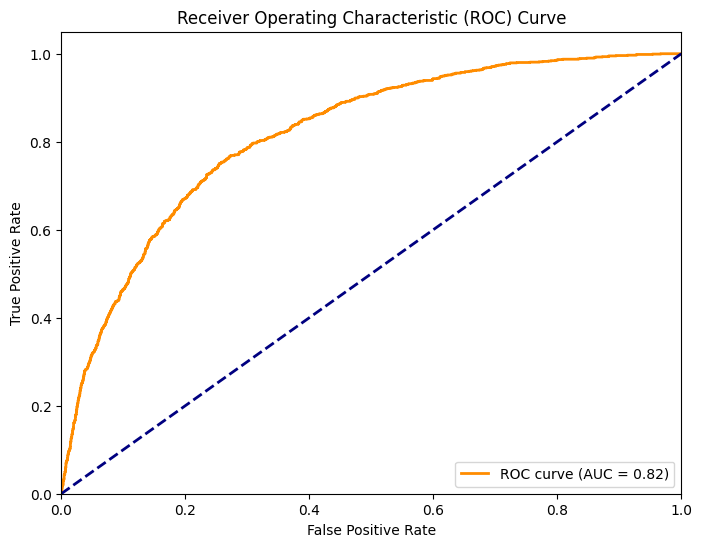

In [24]:
# Cell 9: Compute additional evaluation metrics
# This cell calculates precision, recall, F1-score, confusion matrix, and plots the ROC curve and AUC.
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

y_true = []
y_pred = []
y_scores = []  # Predicted probabilities for ROC

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())
    y_scores.extend(preds.flatten())

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print("Accuracy: {:.2f}%".format(acc * 100))
print("Precision: {:.2f}".format(prec))
print("Recall: {:.2f}".format(rec))
print("F1-Score: {:.2f}".format(f1))
print("Confusion Matrix:\n", cm)
print("AUC: {:.2f}".format(roc_auc))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
